In [1]:
from matplotlib import pyplot as plt

from genolearn.dataloader import DataLoader
from genolearn.metrics import intra_accuracy

import numpy as np

model      = 'random-forest'
complexity = 'max_depths'

o          = 1
d          = 2

dataloader = DataLoader('data-low-memory', 'raw-data/meta-data.csv', 'Accession', 'Region', 'Year')

regions    = set()

Y_test     = []

for year in reversed(range(2014, 2019)):
    _, identifiers = dataloader.load_train_test_identifiers(range(year, 2019), [2019])
    y_test         = dataloader.load_Y(*identifiers)
    Y_test.append(y_test.values)
    regions       |= set(dataloader.encoder)

regions = sorted(regions)

npz     = np.load(f'script-output/{model}.npz')

Y_hat   = npz['predictions']
param   = npz[complexity]

colors  = plt.rcParams['axes.prop_cycle'].by_key()['color']

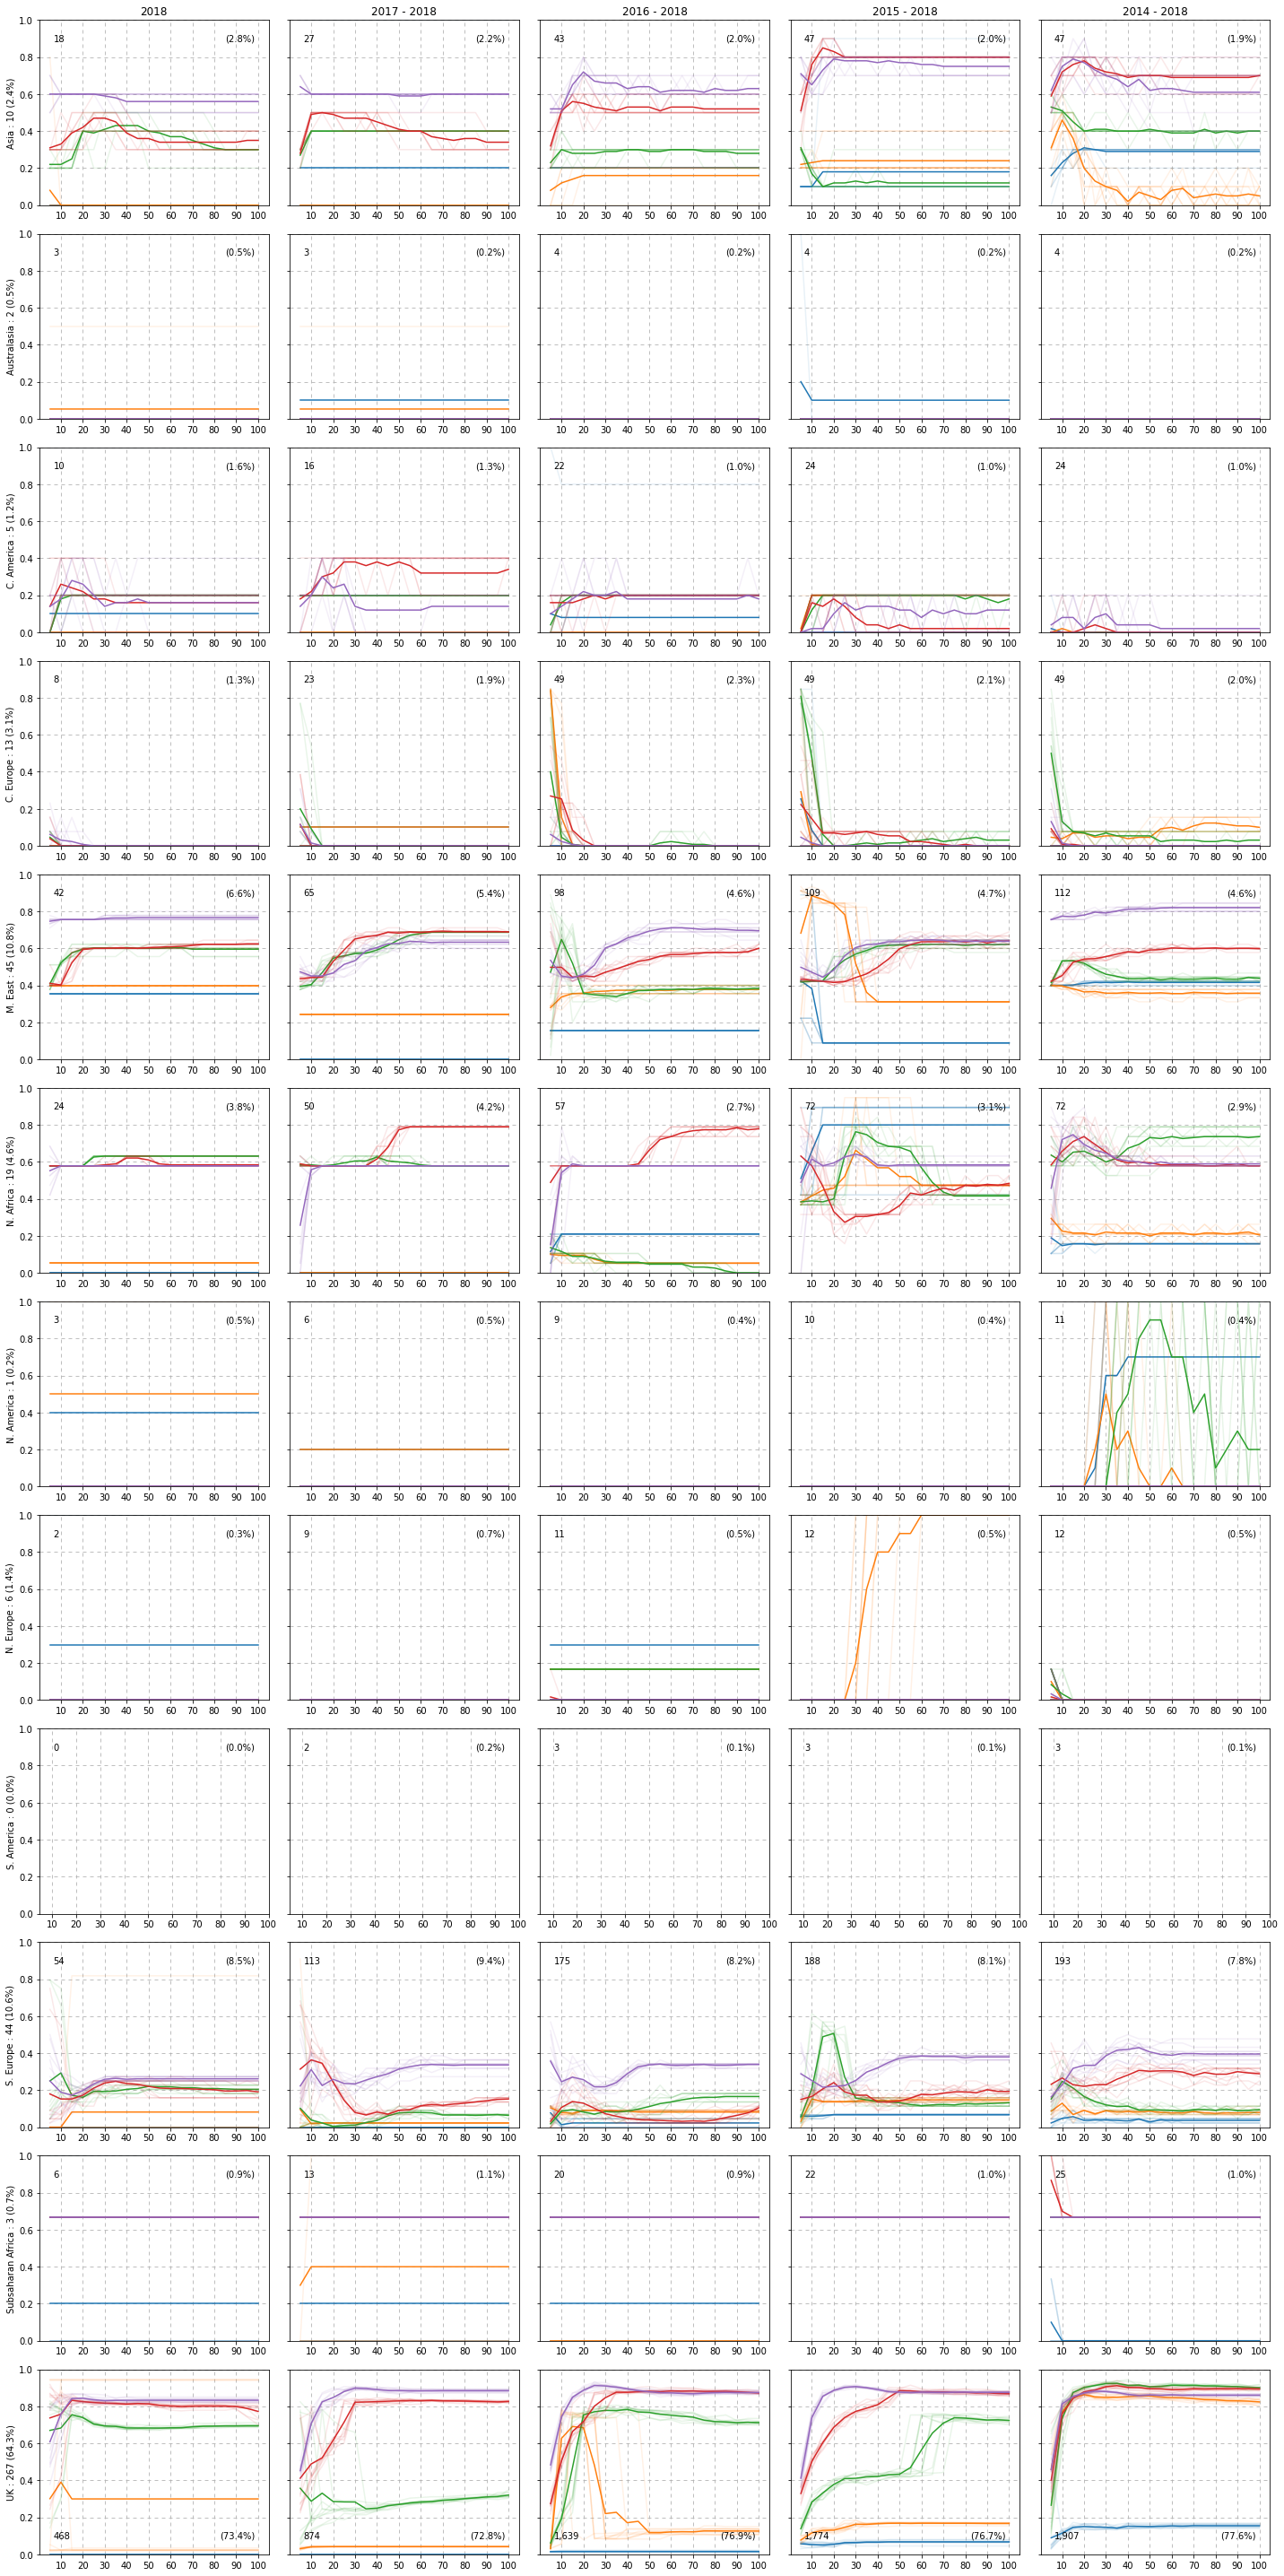

In [2]:
fig, ax  = plt.subplots(12, 5, figsize = (20, 40), sharey = True)

kwargs   = dict(va = 'center', xycoords = 'axes fraction')

for j, year in enumerate(reversed(range(2014, 2019))):
    acc      = intra_accuracy(Y_test[j], Y_hat[j], regions)
    for i, region in enumerate(regions):
        for k, c in enumerate(colors[:5]):
            ax[i,j].plot(acc[i,k], c = c, alpha = 0.1)
            ax[i,j].plot(acc[i,k].mean(axis = -1), c = c)
        y = dataloader.load_Y(*range(2018 - j, 2019)).values
        n = (y == region).sum()
        m = (y == region).mean()
        ax[i,j].set_ylim((0, 1))
        ax[i,j].set_xticks(range(o, len(param), d))
        ax[i,j].set_xticklabels(param[o::d])
        ax[i,j].grid(ls = (0, (5, 5)))
        ax[i,j].annotate(f'{n:,d}', (0.06, 0.1) if i == 11 else (0.06, 0.9), ha = 'left', **kwargs)
        ax[i,j].annotate(f'({m:.1%})', (0.94, 0.1) if i == 11 else (0.94, 0.9), ha = 'right', **kwargs)
        
        if j == 0:
            mask = Y_test[0] == region
            ax[i,0].set_ylabel(f'{region} : {mask.sum():,d} ({mask.mean():.1%})')
    
    title = f'{year} - 2018' if year < 2018 else year
    ax[0,j].set_title(title)

folder = 'doc/_static/generated'

plt.tight_layout()

plt.savefig(f'{folder}/intra-accuracies-{model}.png', dpi = 400)

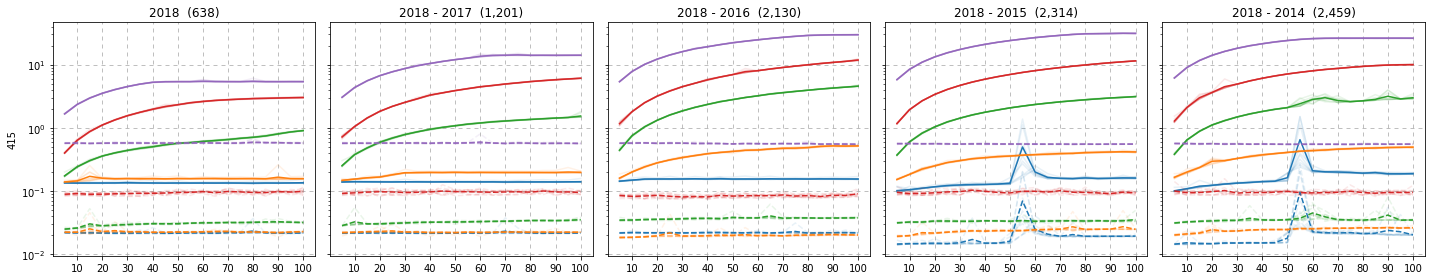

In [3]:
fig, ax = plt.subplots(1, 5, figsize = (20, 4), sharey = True)
times   = npz['times']

for i in range(5):
    for j in range(5):
        for k in range(2):
            ax[i].semilogy(times[i,j,...,k], c = colors[j], alpha = 0.1, ls = ['-', '--'][k])
            ax[i].semilogy(times[i,j,...,k].mean(axis = -1), c = colors[j], ls = ['-', '--'][k])
            ax[i].set_xticks(range(o, len(param), d))
            ax[i].set_xticklabels(param[o::d])
    y = dataloader.load_Y(*range(2018 - i, 2019)).values
    ax[i].grid(ls = (0, (5, 5)))
    ax[i].set_title((f'2018 - {2018 - i}' if i else '2018') + f'  ({len(y):,d})')

y = dataloader.load_Y(2019).values

ax[0].set_ylabel(f'{len(y):,d}')

plt.tight_layout()

plt.savefig(f'{folder}/times-{model}.png', dpi = 400)

In [ ]:
def cross_validation(dataloader, K, *identifiers, feature_selection = None, **params):

    if feature_selection:
        dataloader.load_feature_selection(feature_selection)
        
